In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
import time
import math
from tqdm.auto import tqdm

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report
)
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

In [2]:
os.makedirs("data", exist_ok=True)
os.makedirs("models", exist_ok=True)

In [3]:
X_train, X_test, y_train, y_test = joblib.load("data/train_test_split.joblib")
preprocessor = joblib.load("models/preprocessor.joblib")

In [4]:
positive_label = True if y_train.dtype == 'bool' else 1

In [5]:
print("X_train shape:", X_train.shape)
print("X_test shape :", X_test.shape)
print("y_train distribusi:")
print((y_train.value_counts(normalize=True) * 100).round(2))
print("\ny_test distribusi:")
print((y_test.value_counts(normalize=True) * 100).round(2))

X_train shape: (1163451, 18)
X_test shape : (290863, 18)
y_train distribusi:
Arrest
False    74.09
True     25.91
Name: proportion, dtype: float64

y_test distribusi:
Arrest
False    74.09
True     25.91
Name: proportion, dtype: float64


### Definisikan model-model yang akan dipakai (baseline)

In [6]:
models = {
    "LogisticRegression": LogisticRegression(
        max_iter=1000,
        n_jobs=-1
    ),
    "DecisionTree": DecisionTreeClassifier(
        random_state=42
    ),
    "RandomForest": RandomForestClassifier(
        n_estimators=100,
        random_state=42,
        n_jobs=-1
    ),
    "LightGBM": LGBMClassifier(
        random_state=42,
        n_estimators=200
    ),
    "XGBoost": XGBClassifier(
        random_state=42,
        n_estimators=200,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="logloss", 
        n_jobs=-1
    )
}

print("Model yang akan diuji:", list(models.keys()))

Model yang akan diuji: ['LogisticRegression', 'DecisionTree', 'RandomForest', 'LightGBM', 'XGBoost']


### Function: evaluasi & simpan metrik

In [7]:
def evaluate_classification(y_true, y_pred, y_proba=None, positive_label=1):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, pos_label=positive_label)
    rec = recall_score(y_true, y_pred, pos_label=positive_label)
    f1 = f1_score(y_true, y_pred, pos_label=positive_label)

    auc = None
    if y_proba is not None:
        try:
            auc = roc_auc_score(y_true, y_proba)
        except ValueError:
            auc = None

    return {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "auc": auc
    }

### Feature Selection dengan SelectFromModel

In [8]:
fs_estimator = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

feature_selector = SelectFromModel(
    estimator=fs_estimator,
    threshold="median"
)

### Loop utama: Preprocessing + Sampling + Model dalam 1 pipeline

In [9]:
train_frac = 0.1

train_frac = min(train_frac, 1.0)

if train_frac < 1.0:
    X_train_small, _, y_train_small, _ = train_test_split(
        X_train,
        y_train,
        train_size=train_frac,
        stratify=y_train,
        random_state=42
    )

    print("=== Stratified subsampling dilakukan ===")
    print("Ukuran X_train awal :", X_train.shape[0])
    print("Ukuran X_train_small:", X_train_small.shape[0])
    print("\nDistribusi Arrest di y_train_small:")
    print((y_train_small.value_counts(normalize=True) * 100).round(2))

    X_train_used = X_train_small
    y_train_used = y_train_small
else:
    print("train_frac = 1.0, pakai seluruh X_train")
    X_train_used = X_train
    y_train_used = y_train

=== Stratified subsampling dilakukan ===
Ukuran X_train awal : 1163451
Ukuran X_train_small: 116345

Distribusi Arrest di y_train_small:
Arrest
False    74.09
True     25.91
Name: proportion, dtype: float64


In [10]:
results_fs = []

# 1) Hitung jumlah fitur setelah preprocessing sekali saja
X_test_pre = preprocessor.transform(X_test[:100])
n_features_after_preprocess = X_test_pre.shape[1]
print("Jumlah fitur setelah preprocessing (tanpa FS):", n_features_after_preprocess)

# Bungkus loop model dengan tqdm biar ada progress bar
model_items = list(models.items())

for model_name, model in tqdm(model_items, desc="Models (Feature Selection Scenario)"):
    print("\n==============================")
    print(f"Model: {model_name}")
    print("==============================")

    # =========================================================
    # A. Pipeline TANPA Feature Selection
    #    preprocess -> model
    # =========================================================
    start_time = time.time()

    try:
        pipe_base = Pipeline(steps=[
            ('preprocess', preprocessor),
            ('model', model)
        ])

        pipe_base.fit(X_train_used, y_train_used)

        y_pred_base = pipe_base.predict(X_test)

        y_proba_base = None
        if hasattr(pipe_base.named_steps['model'], "predict_proba"):
            y_proba_base = pipe_base.predict_proba(X_test)[:, 1]

        metrics_base = evaluate_classification(
            y_test, y_pred_base, y_proba_base, positive_label=positive_label
        )

        elapsed = time.time() - start_time

        # Logger mirip skenario 1
        if metrics_base['auc'] is not None:
            print(f"  [NO  FS] -> F1={metrics_base['f1']:.4f} | "
                  f"Recall={metrics_base['recall']:.4f} | "
                  f"AUC={metrics_base['auc']:.4f} | "
                  f"time={elapsed:.2f}s")
        else:
            print(f"  [NO  FS] -> F1={metrics_base['f1']:.4f} | "
                  f"Recall={metrics_base['recall']:.4f} | "
                  f"AUC=- | time={elapsed:.2f}s")

        results_fs.append({
            "model": model_name,
            "feature_selection": "no",
            "n_features": n_features_after_preprocess,
            "train_time_sec": elapsed,
            **metrics_base
        })

    except Exception as e:
        elapsed = time.time() - start_time
        print(f"  !! ERROR (NO FS) pada {model_name}: {e}")
        results_fs.append({
            "model": model_name,
            "feature_selection": "no",
            "n_features": np.nan,
            "train_time_sec": elapsed,
            "accuracy": np.nan,
            "precision": np.nan,
            "recall": np.nan,
            "f1": np.nan,
            "auc": np.nan,
            "error": f"NO_FS: {e}"
        })

    # =========================================================
    # B. Pipeline DENGAN Feature Selection
    #    preprocess -> SelectFromModel(RF) -> model
    # =========================================================
    start_time = time.time()

    try:
        fs_estimator = RandomForestClassifier(
            n_estimators=100,
            random_state=42,
            n_jobs=-1
        )

        feature_selector = SelectFromModel(
            estimator=fs_estimator,
            threshold="median"   # pilih fitur dengan importance di atas median
        )

        pipe_fs = Pipeline(steps=[
            ('preprocess', preprocessor),
            ('feature_selection', feature_selector),
            ('model', model)
        ])

        pipe_fs.fit(X_train_used, y_train_used)

        y_pred_fs = pipe_fs.predict(X_test)

        y_proba_fs = None
        if hasattr(pipe_fs.named_steps['model'], "predict_proba"):
            y_proba_fs = pipe_fs.predict_proba(X_test)[:, 1]

        metrics_fs = evaluate_classification(
            y_test, y_pred_fs, y_proba_fs, positive_label=positive_label
        )

        # Berapa fitur yang dipilih oleh SelectFromModel?
        n_selected = pipe_fs.named_steps['feature_selection'].get_support().sum()

        elapsed = time.time() - start_time

        if metrics_fs['auc'] is not None:
            print(f"  [WITH FS] -> F1={metrics_fs['f1']:.4f} | "
                  f"Recall={metrics_fs['recall']:.4f} | "
                  f"AUC={metrics_fs['auc']:.4f} | "
                  f"n_feat={n_selected} | time={elapsed:.2f}s")
        else:
            print(f"  [WITH FS] -> F1={metrics_fs['f1']:.4f} | "
                  f"Recall={metrics_fs['recall']:.4f} | "
                  f"AUC=- | n_feat={n_selected} | time={elapsed:.2f}s")

        results_fs.append({
            "model": model_name,
            "feature_selection": "yes",
            "n_features": n_selected,
            "train_time_sec": elapsed,
            **metrics_fs
        })

    except Exception as e:
        elapsed = time.time() - start_time
        print(f"  !! ERROR (WITH FS) pada {model_name}: {e}")
        results_fs.append({
            "model": model_name,
            "feature_selection": "yes",
            "n_features": np.nan,
            "train_time_sec": elapsed,
            "accuracy": np.nan,
            "precision": np.nan,
            "recall": np.nan,
            "f1": np.nan,
            "auc": np.nan,
            "error": f"WITH_FS: {e}"
        })

# Jadikan DataFrame
results_fs_df = pd.DataFrame(results_fs)
results_fs_df


Jumlah fitur setelah preprocessing (tanpa FS): 33204


Models (Feature Selection Scenario):   0%|          | 0/5 [00:00<?, ?it/s]


Model: LogisticRegression
  [NO  FS] -> F1=0.7499 | Recall=0.6513 | AUC=0.9049 | time=8.49s
  [WITH FS] -> F1=0.7502 | Recall=0.6508 | AUC=0.9049 | n_feat=12208 | time=111.87s

Model: DecisionTree
  [NO  FS] -> F1=0.7178 | Recall=0.6763 | AUC=0.8053 | time=50.07s
  [WITH FS] -> F1=0.7186 | Recall=0.6757 | AUC=0.8056 | n_feat=12208 | time=150.52s

Model: RandomForest
  [NO  FS] -> F1=0.7413 | Recall=0.6382 | AUC=0.8919 | time=111.85s
  [WITH FS] -> F1=0.7432 | Recall=0.6402 | AUC=0.8925 | n_feat=12208 | time=180.19s

Model: LightGBM
[LightGBM] [Info] Number of positive: 30143, number of negative: 86202
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.053907 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3249
[LightGBM] [Info] Number of data points in the train set: 116345, number of used features: 1370
[LightGBM] [Info] [binary:BoostFro

C:\Users\ASUS\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\ASUS\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


  [NO  FS] -> F1=0.7523 | Recall=0.6434 | AUC=0.9126 | time=6.51s
[LightGBM] [Info] Number of positive: 30143, number of negative: 86202
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055827 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3249
[LightGBM] [Info] Number of data points in the train set: 116345, number of used features: 1370
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.259083 -> initscore=-1.050741
[LightGBM] [Info] Start training from score -1.050741


C:\Users\ASUS\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\ASUS\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


  [WITH FS] -> F1=0.7523 | Recall=0.6434 | AUC=0.9126 | n_feat=12208 | time=108.24s

Model: XGBoost
  [NO  FS] -> F1=0.7490 | Recall=0.6342 | AUC=0.9107 | time=11.30s
  [WITH FS] -> F1=0.7491 | Recall=0.6352 | AUC=0.9110 | n_feat=12208 | time=110.95s


,model,feature_selection,n_features,train_time_sec,accuracy,precision,recall,f1,auc
0,LogisticRegression,no,33204,8.487335,0.887473,0.883797,0.651295,0.749939,0.904882
1,LogisticRegression,yes,12208,111.866096,0.887710,0.885410,0.650804,0.750193,0.904909
2,DecisionTree,no,33204,50.067655,0.862217,0.764698,0.676270,0.717771,0.805341
3,DecisionTree,yes,12208,150.515554,0.862898,0.767323,0.675699,0.718602,0.805601
4,RandomForest,no,33204,111.852772,0.884609,0.884176,0.638211,0.741324,0.891916
5,RandomForest,yes,12208,180.192745,0.885372,0.885692,0.640175,0.743181,0.892463
6,LightGBM,no,33204,6.508033,0.890251,0.905683,0.643386,0.752328,0.912646
7,LightGBM,yes,12208,108.238470,0.890251,0.905683,0.643386,0.752328,0.912646
8,XGBoost,no,33204,11.299342,0.889873,0.914473,0.634243,0.749005,0.910714
9,XGBoost,yes,12208,110.948906,0.889745,0.912674,0.635212,0.749075,0.911034


### Analisis hasil Skenario III

In [11]:
results_sorted_f1 = results_fs_df.sort_values(
    by=["f1", "recall", "precision"],
    ascending=False
).reset_index(drop=True)

print("Hasil Skenario I - diurutkan berdasarkan F1 (terbaik di atas):")
display(results_sorted_f1)

Hasil Skenario I - diurutkan berdasarkan F1 (terbaik di atas):


,model,feature_selection,n_features,train_time_sec,accuracy,precision,recall,f1,auc
0,LightGBM,no,33204,6.508033,0.890251,0.905683,0.643386,0.752328,0.912646
1,LightGBM,yes,12208,108.238470,0.890251,0.905683,0.643386,0.752328,0.912646
2,LogisticRegression,yes,12208,111.866096,0.887710,0.885410,0.650804,0.750193,0.904909
3,LogisticRegression,no,33204,8.487335,0.887473,0.883797,0.651295,0.749939,0.904882
4,XGBoost,yes,12208,110.948906,0.889745,0.912674,0.635212,0.749075,0.911034
5,XGBoost,no,33204,11.299342,0.889873,0.914473,0.634243,0.749005,0.910714
6,RandomForest,yes,12208,180.192745,0.885372,0.885692,0.640175,0.743181,0.892463
7,RandomForest,no,33204,111.852772,0.884609,0.884176,0.638211,0.741324,0.891916
8,DecisionTree,yes,12208,150.515554,0.862898,0.767323,0.675699,0.718602,0.805601
9,DecisionTree,no,33204,50.067655,0.862217,0.764698,0.676270,0.717771,0.805341


In [15]:
pivot_f1_fs = results_fs_df.pivot_table(
    index="model",
    columns="feature_selection",
    values="f1"
)

print("F1-score sebelum vs sesudah Feature Selection:")
display(pivot_f1_fs)

F1-score sebelum vs sesudah Feature Selection:


feature_selection,no,yes
model,,
DecisionTree,0.717771,0.718602
LightGBM,0.752328,0.752328
LogisticRegression,0.749939,0.750193
RandomForest,0.741324,0.743181
XGBoost,0.749005,0.749075


<Figure size 800x500 with 0 Axes>

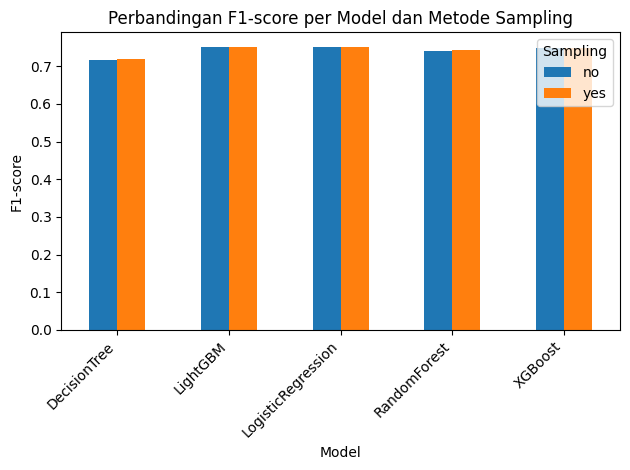

In [17]:
plt.figure(figsize=(8,5))
pivot_f1_fs.plot(kind='bar')
plt.title('Perbandingan F1-score per Model dan Metode Sampling')
plt.xlabel('Model')
plt.ylabel('F1-score')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Sampling')
plt.tight_layout()
plt.show()

In [16]:
pivot_nfeat = results_fs_df.pivot_table(
    index="model",
    columns="feature_selection",
    values="n_features"
)

print("Jumlah fitur sebelum vs sesudah Feature Selection:")
display(pivot_nfeat)

Jumlah fitur sebelum vs sesudah Feature Selection:


feature_selection,no,yes
model,,
DecisionTree,33204.0,12208.0
LightGBM,33204.0,12208.0
LogisticRegression,33204.0,12208.0
RandomForest,33204.0,12208.0
XGBoost,33204.0,12208.0


<Figure size 800x500 with 0 Axes>

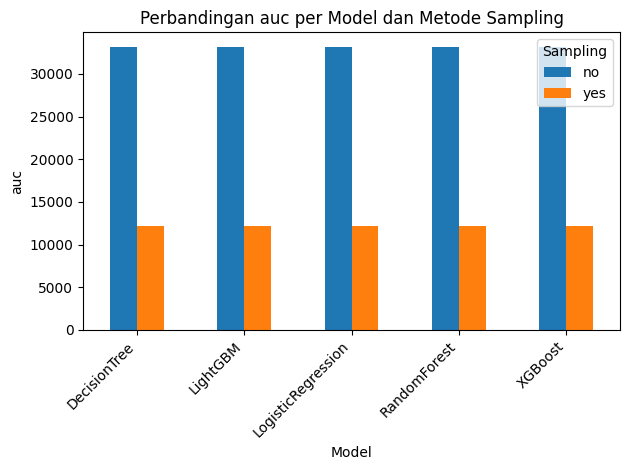

In [18]:
plt.figure(figsize=(8,5))
pivot_nfeat.plot(kind='bar')
plt.title('Perbandingan auc per Model dan Metode Sampling')
plt.xlabel('Model')
plt.ylabel('auc')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Sampling')
plt.tight_layout()
plt.show()

### Simpan hasil Skenario III

In [19]:
os.makedirs("results", exist_ok=True)
results_fs_df.to_csv("results/skenario3_feature_selection_results.csv", index=False)